**Reinforcement Learning with TensorFlow & TRFL: Pixel Control**

Outline:
* Pixel Control
* Pixel Control with a DQN and Pong: trfl.pixel_control_loss()

In [0]:
# Check for GPU. If GPU is not found go to Edit and Notebook settings to enable GPU

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#install TRFL
!pip install trfl==1.0.1

    100% |████████████████████████████████| 81kB 3.8MB/s 


In [0]:
import gym
import trfl
import numpy as np
from collections import deque
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer(object):
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,), np.array(d).reshape(-1,)
    
    # sample a sequence of consecutive frames for pixel control
    def pixel_sample(self, sequence_len):
        ind = np.random.randint(0, len(self.storage)-sequence_len)
        x, u, = [], []
        for i in range(ind,ind+sequence_len):
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            u.append(np.array(U, copy=False))
        return np.array(x), np.array(u[:-1]).reshape(-1,1)

In [0]:
# preprocess images with wrappers from: https://github.com/openai/baselines/baselines/common/atari_wrappers.py

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        if self.grayscale:
            self.observation_space = spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 1), dtype=np.uint8)
        else:
            self.observation_space = spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 3), dtype=np.uint8)

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env, width=80, height=80)
    env = MaxAndSkipEnv(env, skip=4)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env
  

** Pixel Control **

By using the auxiliary task pixel control, the agent tries to learn to predict and control the stream by seeking to maximize change in pixel intensity in different regions of the input. In the UNREAL paper this is done by using a deconvolutional network. The LSTM outputs are used as inputs for the deconvolutional network. Pixel control performs better than alternative methods like predicting pixel changes or trying to reconstruct the image input.


** Pixel Control with a DQN and Pong: trfl.pixel_control_loss() **

In this example we use a DQN network without a LSTM instead of the A3C network with a LSTM used in the UNREAL paper. The deconvolutional network is based on the UNREAL implementation found here: https://github.com/miyosuda/unreal

We use the DQN and  pixel control loss to train an agent to play the classic Atari game Pong.







In [0]:
class PixelLossDQN:
    def __init__(self, name, learning_rate=0.01, image_height=80, image_width=80, action_size=2, hidden_size=10, 
                 batch_size=20, discount=0.99, pixel_loss_coeff=0.001, cell_size=4, scale = 1/255.):
        
        with tf.variable_scope(name):
          with tf.device('/gpu:0'):
            self.name = name
            # set up tensors for DQN
            self.input_ = tf.placeholder(tf.float32, [None, image_height, image_width, 4], name='inputs')
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.targetQ_ = tf.placeholder(tf.float32, [batch_size, action_size], name='target')
            self.trainQ_next_ = tf.placeholder(tf.float32, [batch_size, action_size], name='trainQ_next')
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(discount,shape=[batch_size],dtype=tf.float32,name="discount")
            
            # scale the image inputs to the 0 to 1 range
            self.scaled_input_ = self.input_ / 255.
            
            # DQN
            # Nature CNN from: https://github.com/openai/baselines/blob/1b092434fc51efcb25d6650e287f07634ada1e08/baselines/common/models.py
            self.cnn1_ = tf.contrib.layers.conv2d(self.scaled_input_, 32, kernel_size=8, stride=4, activation_fn=tf.nn.relu, 
                                        padding="VALID", weights_initializer=tf.initializers.orthogonal(gain=np.sqrt(2)))
            self.cnn2_ = tf.contrib.layers.conv2d(self.cnn1_, 64, kernel_size=4, stride=2, activation_fn=tf.nn.relu, 
                                        padding="VALID", weights_initializer=tf.initializers.orthogonal(gain=np.sqrt(2)))
            self.cnn3_ = tf.contrib.layers.conv2d(self.cnn2_, 64, kernel_size=3, stride=1, activation_fn=tf.nn.relu, 
                                        padding="VALID", weights_initializer=tf.initializers.orthogonal(gain=np.sqrt(2)))
            self.flat_ = tf.contrib.layers.flatten(self.cnn3_)
            # fully connected layers
            self.fc1_ = tf.contrib.layers.fully_connected(self.flat_, hidden_size, activation_fn=tf.nn.relu)
            # linear output layer
            self.dqn_out_ = tf.contrib.layers.fully_connected(self.fc1_, action_size, activation_fn=None)

            # TRFL double qlearning
            qloss, qextra = trfl.double_qlearning(self.dqn_out_, self.action_, self.reward_, 
                                                      self.discount_, self.targetQ_, self.trainQ_next_)
            
            # tensors for pixel control
            self.pixel_dqn_ = tf.placeholder( tf.float32, shape=[None, action_size] )
            self.pixel_obs_ = tf.placeholder(tf.float32, [None, 1, image_height, image_width, 4], 
                                             name='pixel_obs')
            self.pixel_discount_ = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="pixel_discount")
            self.pixel_action_ = tf.placeholder(tf.int32, shape=[None, 1], name='pixel_actions')
            
            # create FC layer from dqn outputs to deconvolutional network
            spatial_map = 9*9*32
            spatial_fc1_ = tf.contrib.layers.fully_connected(self.pixel_dqn_, spatial_map, activation_fn=tf.nn.relu)
            pre_deconv_ = tf.reshape(spatial_fc1_, [-1, 9, 9, 32])
            # create deconv network variables
            filter_v_ = tf.get_variable('filter_v', shape=[cell_size, cell_size, 1, 32], dtype=tf.float32)
            filter_a_ = tf.get_variable('filter_a', shape=[cell_size, cell_size, num_actions, 32], dtype=tf.float32)
            # create deconv network layers
            output_h = image_height//cell_size
            output_w = image_width//cell_size
            value_deconv_ = tf.nn.conv2d_transpose(pre_deconv_, filter_v_, 
                                       output_shape=[batch_size,output_h,output_w,1],
                                       strides=[1,2,2,1], padding='VALID')
            action_deconv_ = tf.nn.conv2d_transpose(pre_deconv_, filter_a_, 
                                       output_shape=[batch_size,output_h,output_w,num_actions],
                                       strides=[1,2,2,1], padding='VALID')
            action_mean_ = tf.reduce_mean(action_deconv_, reduction_indices=3, keepdims=True)
            self.pixel_qvalue_out_ = value_deconv_ + action_deconv_ - action_mean_
            self.pixel_qvalue_ = tf.expand_dims(self.pixel_qvalue_out_,axis=1)

            # TRFL pixel control loss
            self.pixel_return_ = trfl.pixel_control_loss(self.pixel_obs_, self.pixel_action_, self.pixel_qvalue_,
                                                         cell_size, self.pixel_discount_, scale=scale, 
                                                         crop_height_dim=(None,None), crop_width_dim=(None, None))
            
            # combine the DQN and pixel control losses for optimizing
            self.huber_loss_ = trfl.huber_loss(qextra.td_error, 1.0)
            self.pixel_loss_ = pixel_loss_coeff * self.pixel_return_.loss
            self.losses_ = self.huber_loss_ + self.pixel_loss_
            self.loss_ = tf.reduce_mean(self.losses_)
            self.opt_ = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_)

            
    def get_qnetwork_variables(self):
        return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]    


** TRFL Usage **

We create a DQN with a CNN in the first part of the PixelLossDQN class. As seen in earlier videos we use trfl.double_qlearning() and trfl.huber_loss() for the DQN. In the latter part of the class we define the pixel control tensors and the deconvolutional network. The output of the DQN feeds into the deconvolutional network. The output of the deconvolutional network and the pixel control tensors are inputted into trfl.pixel_control_loss() to get the pixel control loss. We combine the Huber and pixel control loss and optimize trying to minimize both of them.


In [0]:
env = gym.make('PongNoFrameskip-v4')

# wrap env
env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False) #scale in DQN
seed = 31
env.seed(seed)
np.random.seed(seed)

# pixel control hyperparameters
cell_size = 4 #size of grids for maximizing pixel change intensity over
pixel_loss_coeff = 1e-4 #scales the pixel control loss versus the main loss
pixel_loss_discount = 0.9 #discount factor for pixel control loss
pixel_sequence_len = 32 #length of sequence to train pixel loss over
scale = 1/255. #scale images by
image_height = 80
image_width = 80

# hyperparameters
timesteps = 2000000
replay_size = 50000
hidden_size = 512
learning_rate = 0.0001
batch_size = 32
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay_steps = timesteps * .15
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps)
update_target_every = 1000
start_training_after = 10000
discount = 0.99
num_actions = env.action_space.n

#declare TRFL in graph
tf.reset_default_graph()
trainQN = PixelLossDQN(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate, batch_size=batch_size,
                  action_size=num_actions, discount=discount, cell_size=cell_size, pixel_loss_coeff=pixel_loss_coeff,
                  image_height=image_height, image_width=image_width, scale=scale)
targetQN = PixelLossDQN(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate, batch_size=batch_size,
                   action_size=num_actions, discount=discount, cell_size=cell_size, pixel_loss_coeff=pixel_loss_coeff,
                   image_height=image_height, image_width=image_width, scale=scale)

#target network updating
target_network_update_op = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(), tau=1.0/update_target_every)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.


** The Reinforcment Learning Loop **

In the RL loop we train a DQN as in section 2. We collect experience, store it in a replay buffer, and sample from the buffer to train the network. We also update the target network.

We also sample from the replay buffer to get sequences of data for the pixel control loss. Unlike the DQN where we randomly sample data from the buffer, for pixel control we grab a sequence of experience from the buffer using replay_buffer.pixel_sample(), reshape the data and input the data into the session's feed dict.

In [0]:
# create replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)
episode, ep_length, total_reward = 1, 0, 0
epsilon = epsilon_start
stats_rewards_list = []
stats_every = 10
state = env.reset()
stats_loss = 0.

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for ts in range(timesteps):
        # epsilon greedy exploration
        if np.random.rand() <= epsilon:
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            feed = {trainQN.input_: np.reshape(state,(1,image_height,image_width,4))}
            action_values = sess.run(trainQN.dqn_out_, feed_dict=feed)
            action = np.argmax(action_values)
        epsilon -= epsilon_step
        if epsilon < epsilon_min:
            epsilon = epsilon_min
            
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        ep_length += 1

        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward, done))

        # train the network
        if ts > start_training_after:
            state_batch, next_state_batch, action_batch, reward_batch, done_batch = replay_buffer.sample(batch_size)
            
            # get Q network next state values
            target_Q = sess.run(targetQN.dqn_out_, feed_dict={targetQN.input_: next_state_batch})
            train_Q = sess.run(trainQN.dqn_out_, feed_dict={trainQN.input_: next_state_batch})
            
            pixel_state_batch, pixel_action_batch = replay_buffer.pixel_sample(pixel_sequence_len)
            pixel_discount_batch = np.array([pixel_loss_discount]*len(pixel_action_batch)).reshape(len(pixel_action_batch),1)
            
            # get DQN values from the pixel_state_batch. These values are fed into deconv net
            pixel_Q = sess.run(targetQN.dqn_out_, feed_dict={targetQN.input_: pixel_state_batch})
            pixel_state_batch = np.expand_dims(pixel_state_batch,axis=1)

            stats_loss, _, stats_huber_loss, stats_pixel_loss = sess.run([trainQN.loss_, trainQN.opt_, 
                                                                          trainQN.huber_loss_, trainQN.pixel_loss_],
                                feed_dict={trainQN.input_: state_batch,
                                           trainQN.targetQ_: target_Q,
                                           trainQN.reward_: reward_batch,
                                           trainQN.action_: action_batch,
                                           trainQN.trainQ_next_: train_Q,
                                           trainQN.pixel_dqn_: pixel_Q,
                                           trainQN.pixel_obs_:pixel_state_batch,
                                           trainQN.pixel_action_:pixel_action_batch,
                                           trainQN.pixel_discount_:pixel_discount_batch})
            # update target networks
            sess.run(target_network_update_op)
    
        if done:
            stats_rewards_list.append((episode, total_reward, ep_length))
            state = env.reset()
            episode += 1
            if ts > start_training_after and episode % stats_every == 0:
                print('Episode: {}'.format(episode),
                    'Timestep: {}'.format(ts),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Epsilon: {:.2f}'.format(epsilon),
                    'Total Loss: {:.5f}'.format(stats_loss),
                    'Huber Loss: {:.5f}'.format(np.mean(stats_huber_loss)),
                    'Pixel Loss: {:.5f}'.format(np.mean(stats_pixel_loss)))
            total_reward, ep_length = 0, 0

            if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 19:
                print("Stopping at episode {} with average rewards of {} in last {} episodes".
                    format(episode, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
                break    
        else:
            state = next_state

Episode: 20 Timestep: 17378 Total reward: -20.2 Episode length: 922.1 Epsilon: 0.94 Total Loss: 0.00179 Huber Loss: 0.00145 Pixel Loss: 0.00034
Episode: 30 Timestep: 26994 Total reward: -20.0 Episode length: 961.6 Epsilon: 0.91 Total Loss: 0.00442 Huber Loss: 0.00399 Pixel Loss: 0.00044
Episode: 40 Timestep: 36639 Total reward: -19.6 Episode length: 964.5 Epsilon: 0.88 Total Loss: 0.00538 Huber Loss: 0.00506 Pixel Loss: 0.00032
Episode: 50 Timestep: 47062 Total reward: -20.0 Episode length: 1042.3 Epsilon: 0.84 Total Loss: 0.00528 Huber Loss: 0.00483 Pixel Loss: 0.00044
Episode: 60 Timestep: 57786 Total reward: -19.1 Episode length: 1072.4 Epsilon: 0.81 Total Loss: 0.00477 Huber Loss: 0.00445 Pixel Loss: 0.00032
Episode: 70 Timestep: 69292 Total reward: -19.4 Episode length: 1150.6 Epsilon: 0.77 Total Loss: 0.00991 Huber Loss: 0.00960 Pixel Loss: 0.00031
Episode: 80 Timestep: 80906 Total reward: -19.8 Episode length: 1161.4 Epsilon: 0.73 Total Loss: 0.01376 Huber Loss: 0.01323 Pixel Lo

Text(0, 0.5, 'Total Reward')

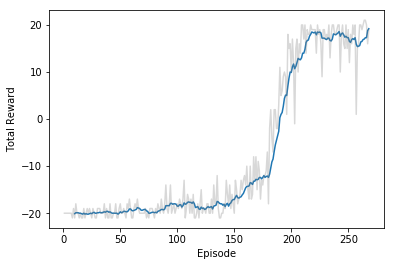

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, ep_len = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')